In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import os
from PIL import Image
from typing import Tuple
from tqdm.auto import tqdm, trange
import torchvision.transforms.functional as f


Load data

train: 10000  
valid: 200  
test: 420

In [2]:
train_df = pd.read_csv("data/train-small.csv")
valid_df = pd.read_csv("data/valid-small.csv")
test_df = pd.read_csv("data/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


Kiểm tra rò rỉ dữ liệu

In [4]:
def check_leakage(df1, df2, column):
    """
    Kiểm tra rò rỉ dữ liệu giữa hai DataFrame dựa trên một cột.
    Trả về True nếu không có giá trị trùng lặp, False nếu có rò rỉ.
    """
    overlap = set(df1[column]).intersection(set(df2[column]))
    if len(overlap) == 0:
        return True
    else:
        return False

In [5]:
print(f"Check_leakage train - test : {check_leakage(train_df,test_df,'PatientId')}")
print(f"Check_leakage valid - test : {check_leakage(valid_df,test_df,'PatientId')}")

Check_leakage train - test : True
Check_leakage valid - test : True


In [6]:
print(f"Check_leakage train - valid : {check_leakage(train_df,valid_df,'PatientId')}")

Check_leakage train - valid : False


In [7]:
overlap = set(train_df['PatientId']).intersection(set(valid_df['PatientId']))
train_df = train_df[~train_df['PatientId'].isin(overlap)]

In [8]:
print(f"Check_leakage train - valid : {check_leakage(train_df,valid_df,'PatientId')}")

Check_leakage train - valid : True


In [9]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [10]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, image_dir, labels, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load ảnh
        image_path = f"{self.image_dir}/{self.df.iloc[idx]['Image']}"
        image = Image.open(image_path).convert("RGB")

        # Lấy nhãn tương ứng, dạng vector 0/1 theo thứ tự trong labels
        label_vector = torch.tensor(
            self.df.iloc[idx][self.labels].values.astype('float32')
        )
        if self.transform:
            image = self.transform(image)

        return image, label_vector

In [11]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ChestXrayDataset(train_df, './data/images_small',labels, transform_train)
valid_dataset = ChestXrayDataset(valid_df, './data/images_small',labels, transform)
test_dataset =  ChestXrayDataset(test_df, './data/images_small',labels, transform)

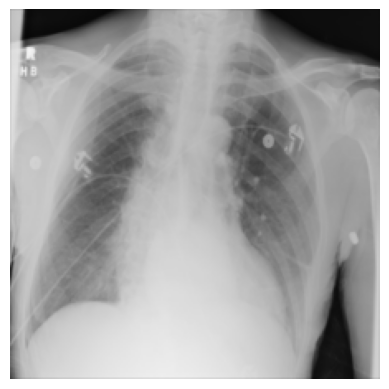

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [14]:
# Lấy ảnh và nhãn đầu tiên từ dataset
image, label = test_dataset[5]

# chuyển sang numpy và đưa về [H,W,C]
if isinstance(image, torch.Tensor):
    image = f.to_pil_image(image)
plt.imshow(image, cmap='gray') 
plt.axis("off")
plt.show()
print(label)

In [16]:
class Bottleneck(nn.Module):
    expansion = 4  # output_channels = out_channels * 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample 

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)
        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=14):  # 14 diseases
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottleneck, 64, blocks=3)
        self.layer2 = self._make_layer(Bottleneck, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [17]:
def evaluate(net: nn.Module, data, threshold=0.5) -> float:
    data_loader = torch.utils.data.DataLoader(data,
                                              batch_size=100,
                                              shuffle=False)
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            
            outputs = net(inputs)
            probs = torch.sigmoid(outputs)  
            preds = (probs > threshold).float() 
            correct += (preds == targets).all(dim=1).sum().item()
            total += targets.size(0)

    return correct / total

In [18]:
def train(train_data,
          val_data,
          net,
          **kwargs) -> Tuple[nn.Module, list[float], list[float], list[float]]:
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=kwargs['batch_size'], shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data, batch_size=kwargs['batch_size'], shuffle=False)

    optimizer = opt.Adam(net.parameters(), lr=kwargs['lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kwargs['epochs'])
    criterion = nn.BCEWithLogitsLoss()  # Multi-label loss

    pbar = trange(kwargs['epochs'])
    for epoch in pbar:
        net.train()
        running_loss = 0.0

        for inputs, targets in tqdm(train_loader, leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device).float() 

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            running_loss += loss.item()

        scheduler.step()

        # Đánh giá train
        train_accuracy = evaluate(net, train_data)
        train_accuracies.append(train_accuracy)

        # Đánh giá validation
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device).float()
                outputs = net(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_accuracy = evaluate(net, val_data)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        pbar.set_description(
            f"Epoch {epoch+1} | TrainLoss: {running_loss/len(train_loader):.4f} | "
            f"TrainAcc: {train_accuracy:.4f} | ValLoss: {val_loss:.4f} | ValAcc: {val_accuracy:.4f}"
        )

    return net, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
net = ResNet50()
lr = 0.005
batch_size = 10
epochs = 70
net, train_losses, train_accuracies = train(train_data=train_dataset,
                                            val_data=valid_dataset,
                                            net=net,
                                            lr=lr,
                                            optimizer='adam',
                                            batch_size=batch_size,
                                            epochs=epochs)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

KeyboardInterrupt: 